In [51]:
import json
import numpy as np
import pandas as pd
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import PIL
from PIL import ImageDraw

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set(style='white', context='notebook', palette='deep')

Populating the interactive namespace from numpy and matplotlib


/Users/Denis/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [52]:
def im2arr(drawing):
    # Original images are 255x255, add extra 2.5 to each edge.
    im = PIL.Image.new(mode='L', size=(260, 260))
    draw = PIL.ImageDraw.Draw(im)

    # Shift the strokes from edges by 2.5 pixels, convert them to valid format.
    for stroke in drawing:
        stroke_shifted = list(map(lambda x: tuple([i+2.5 for i in x]), 
                                  tuple(zip(stroke[0], stroke[1])))
                             )
        draw.line(stroke_shifted, fill=255, width=3)

    im = im.resize((56, 56), resample=3)
    im = np.array(im)
    # Clip max values to make lines less blury.
    return im.clip(0, int(im.max()/2))

In [53]:
df = pd.read_csv('data/df.csv')
train = np.load('data/strokes_raw.npy')
px = im2arr(train[0]).shape[1]

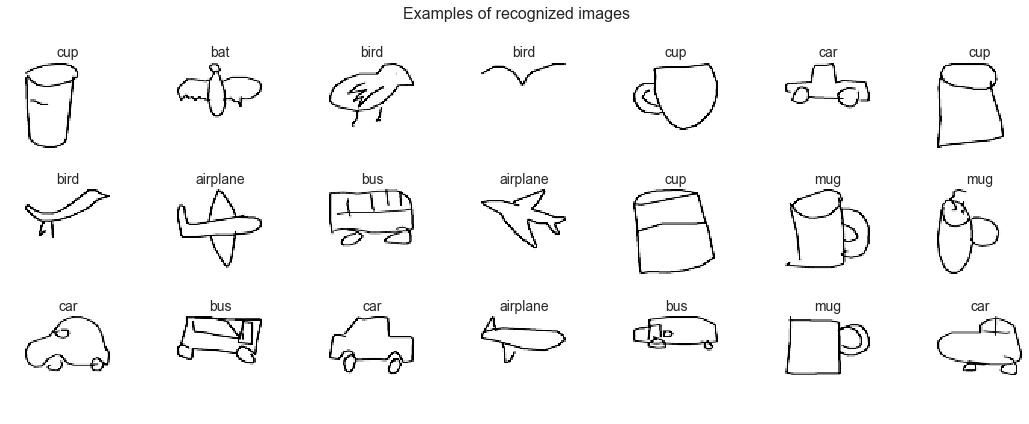

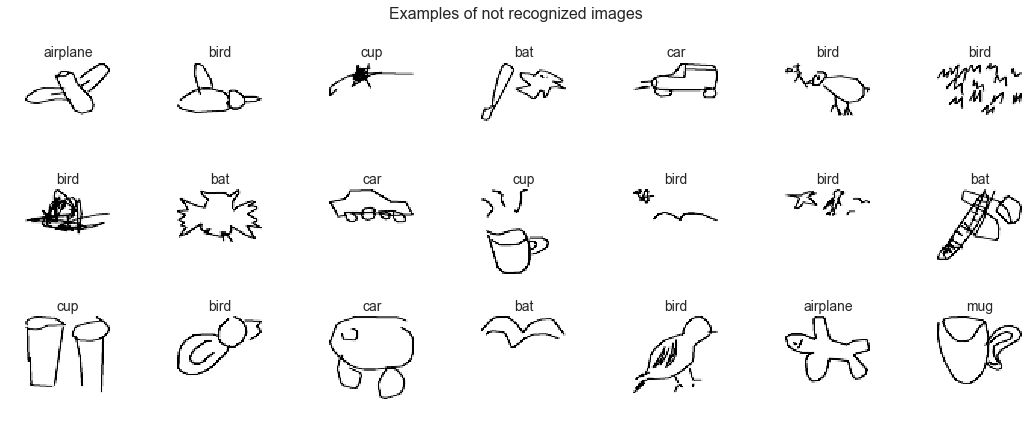

In [54]:
def plot_on_grid(title, recognized):
    fig = plt.figure(figsize=(15,6))
    nrows, ncols = 3, 7
    fig.suptitle(title, fontsize=16)
    img_ids = np.random.choice(df[df.recognized==recognized].index, nrows*ncols)

    for i in range(nrows * ncols):
        image_ind = img_ids[i]
        ax = fig.add_subplot(nrows, ncols, i+1)        
        ax.axis('off')
        ax.imshow(im2arr(train[image_ind]))
        ax.set_title(df.target.loc[image_ind], fontsize=14)
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    
plot_on_grid("Examples of recognized images", 1)
plot_on_grid("Examples of not recognized images", 0)

In [55]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

le = LabelEncoder()
ytrain = le.fit_transform(df.target.values)
ytrain = to_categorical(ytrain).astype(int)

train, valid, ytrain, yvalid, df, dfvalid = train_test_split(train, ytrain, df, test_size=0.1)
np.save('classes.npy', le.classes_)

In [56]:
# Leave only recognized samples for training.
train = train[df.recognized==1]
ytrain = ytrain[df.recognized==1]

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [58]:
def batch_generator(X, y, BATCH_SIZE, EPOCH_PARTION):
    """
    Batch generator for nnet training
    input:
        X - train dataset,  numpy array or csr matrix
        y - target, numpy array
        BATCH_SIZE - int, number of objects in batch. If X is csr matrix, it will be transformed 
        to dense array so batch size must be small enough for this array to fit in memory
        EPOCH_PARTION - float, share of objects that will be used for training in epoch
        
    Important: in this implementation each batch is constructed from random objects from train.
    """
    
    batch_number = 0
    batches_per_epoch = int(X.shape[0]/BATCH_SIZE*EPOCH_PARTION)
    while True:
        batch_indexes = np.random.choice(X.shape[0], BATCH_SIZE)
        X_batch = X[batch_indexes]
        X_batch = np.array([im2arr(drawing) for drawing in X_batch])
        X_batch = X_batch.reshape(-1, px, px, 1)
        y_batch = y[batch_indexes]
        batch_number += 1
        yield X_batch, y_batch
        if batch_number == batches_per_epoch-1:
            batch_number = 0
            
def batch_generator_p(X, BATCH_SIZE):
    """
    Batch generator for nnet predicitons
    input:
        X - train dataset,  numpy array or csr matrix
        BATCH_SIZE - number of objects in batch. If X is csr matrix, it will be transformed 
        to dense array so batch size must be small enough for this array to fit in memory        
    """
     
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/BATCH_SIZE)
    batch_number = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_indexes = sample_index[BATCH_SIZE*batch_number : BATCH_SIZE*(batch_number+1)]
        X_batch = X[batch_indexes]
        X_batch = np.array([im2arr(drawing) for drawing in X_batch])
        X_batch = X_batch.reshape(-1, px, px, 1)
        batch_number += 1
        yield (X_batch)
        if batch_number == number_of_batches:
            batch_number = 0

In [59]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                 input_shape = (px, px, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(ytrain.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=1e-4),
              metrics=["accuracy"])

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 54, 54, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 54, 54, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [61]:
EPOCH_PARTION = 0.1
BATCH_SIZE = 512

early_stopper = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath='nnet_v1_recognized.h5', monitor='val_acc', save_best_only=True)

model.fit_generator(
    generator=batch_generator(train, ytrain, BATCH_SIZE, EPOCH_PARTION),
    samples_per_epoch=np.ceil(train.shape[0]/BATCH_SIZE*EPOCH_PARTION),
    
    validation_data=batch_generator(valid, yvalid, BATCH_SIZE, EPOCH_PARTION),
    validation_steps = np.ceil(valid.shape[0]/BATCH_SIZE),
    
    verbose=1, nb_epoch=200,
    callbacks=[early_stopper, checkpoint]

    #use_multiprocessing=True,
    #workers=2
)

/Users/Denis/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/Users/Denis/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., epochs=200, steps_per_epoch=108.0, validation_steps=137.0, verbose=1, validation_data=<generator..., callbacks=[<keras.ca...)`


Epoch 1/200
108/108 [==============================] - 711s 7s/step - loss: 1.7610 - acc: 0.3436 - val_loss: 1.3304 - val_acc: 0.4900

In [25]:
model.save('nnet_v1.h5')
model.save('nnet_v1_recognized.h5')
#8342

In [ ]:
i = 95
plt.imshow(train[i].reshape(56,56))
preds = model.predict(train[i].reshape(1, px, px, 1))
print(le.classes_[preds.argmax()], preds.max())

In [62]:
from sklearn.metrics import confusion_matrix
y_hat = model.predict_generator(generator=batch_generator_p(valid, BATCH_SIZE), 
                                val_samples=np.ceil(valid.shape[0]/BATCH_SIZE))
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(yvalid, axis=1)
confusion = np.array(confusion_matrix(y_true, y_pred))
print(confusion)

/Users/Denis/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/Users/Denis/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(generator=<generator..., steps=137.0)`
  app.launch_new_instance()


[[9514   92  180   34   44  123   53]
 [ 658 7948  726   22   56  394  188]
 [ 994  449 7877   11   67  404  136]
 [  69   21   34 9351  327  143   70]
 [ 213   69   91  634 8853  100   57]
 [  48   51   90   15   16 6827 3066]
 [  67   56  101   19   21 2026 7595]]


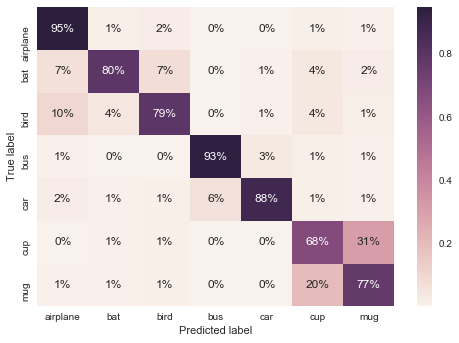

In [63]:
sns.heatmap(confusion.astype('float') / confusion.sum(axis=1),
            fmt='.0%',
            annot=True, 
            xticklabels=list(le.classes_),
            yticklabels=list(le.classes_),
           )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

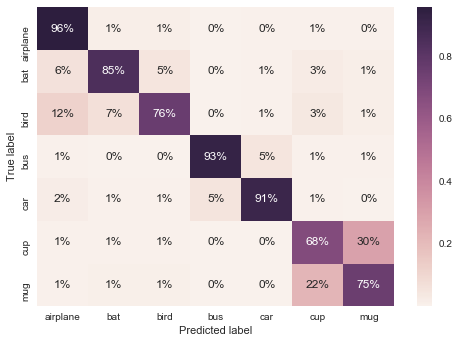

In [13]:
sns.heatmap(confusion.astype('float') / confusion.sum(axis=1),
            fmt='.0%',
            annot=True, 
            xticklabels=list(le.classes_),
            yticklabels=list(le.classes_),
           )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

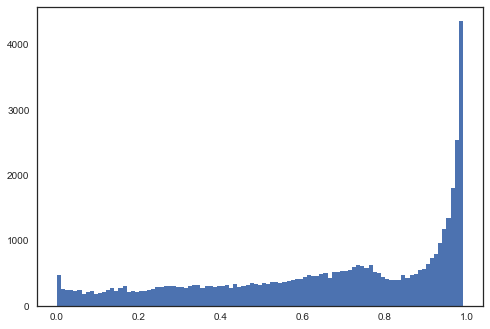

In [26]:
plt.hist(y_hat[range(y_hat.shape[0]), np.argmax(yvalid, axis=1)], bins=np.arange(0,1,0.01));

In [ ]:
mask = y_hat[range(y_hat.shape[0]), np.argmax(yvalid, axis=1)]>0.95

In [19]:
import keras
model2 =  keras.models.load_model('nnet_v1.h5')

In [ ]:
i = 4
print(le.classes_[np.argmax(yvalid[mask][i])])
plt.imshow(valid[mask][i].reshape(px, px))

In [15]:
from PIL import Image
import PIL

In [24]:
img = Image.open('f2.jpg')

for resample in [PIL.Image.HAMMING,  3]:
    img2 = img.resize((px,px), resample=resample)
    img2 = np.array(img2)[:, :, 0].astype(float)
    img2 = - img2 + img2.max()
    img2 = img2.clip(0, img2.max()/2)
    
    preds = model.predict(img2.reshape(1, px, px, 1))
    print(le.classes_[preds.argmax()], preds.max())
    print(preds)
    print()

car 0.956563
[[  9.80222318e-03   1.92881314e-04   1.50781765e-04   3.32523696e-02
    9.56562698e-01   3.26489862e-05   6.51887694e-06]]

car 0.942948
[[  9.03170742e-03   2.97074730e-04   2.38422086e-04   4.74045686e-02
    9.42948461e-01   6.61608356e-05   1.35568152e-05]]



In [ ]:
plt.imshow(img2)

In [ ]:
plt.imshow(train[4].reshape(px, px))

In [ ]:
train[0].max()

In [ ]:
plt.figure(figsize(2,2))
plt.imshow(img2.reshape(1, px, px, 1).reshape(px, px))
plt.axis('off');

In [ ]:
model.predict(img2.reshape(1, px, px, 1))

In [ ]:
le.classes_

In [ ]:
ytrain